In [1]:
import setup


In [2]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/projects/Distributed_Q_gates_clean/Codes/setup.py'>

In [3]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from joblib import delayed, Parallel, parallel_backend
from math import pi as π

In [4]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20})

# Scattering of an even superposition of modes

In [5]:
def flat_photon_scattering(ω1=2*π*8.406, ω2=2*π*8.406, κ2=0.0540353936, l=5, mmax=105):
    
    control = setup.Exp2QB2Cavities(ω1=2*π*8.406, ω2=2*π*8.406, δ2=0, g2=0, κ1=0, κ2=κ2, l=l, mmax=mmax)
    
#     A = setup.evolve_time_dependent(setup.qubit_control_symm(a, setup.control_constant, tmax = 0), 
#     setup.step_photon(mmax), t=2*a.tprop, nsteps=np.int(2*a.tprop))

    duration = 2*control.tprop
    
    v0 = setup.step_photon(mmax)
    
    vt2 = scipy.sparse.linalg.expm_multiply(-1j * duration * control.Hamiltonian(), v0)  
    
    phases = np.angle(setup.step_photon(mmax)[4:]*vt2[4:]*np.exp(1j * control.ωrelevant * duration))/π
    
    return control.ωrelevant, phases, control.κ2*1e-9, control.ω2

In [6]:
scattering_5m = flat_photon_scattering(l=5, κ2=2*π*80*1e-3 )
scattering_15m = flat_photon_scattering(l=15, κ2=2*π*25*1e-3 )
scattering_30m = flat_photon_scattering(l=30, κ2=2*π*20*1e-3 )

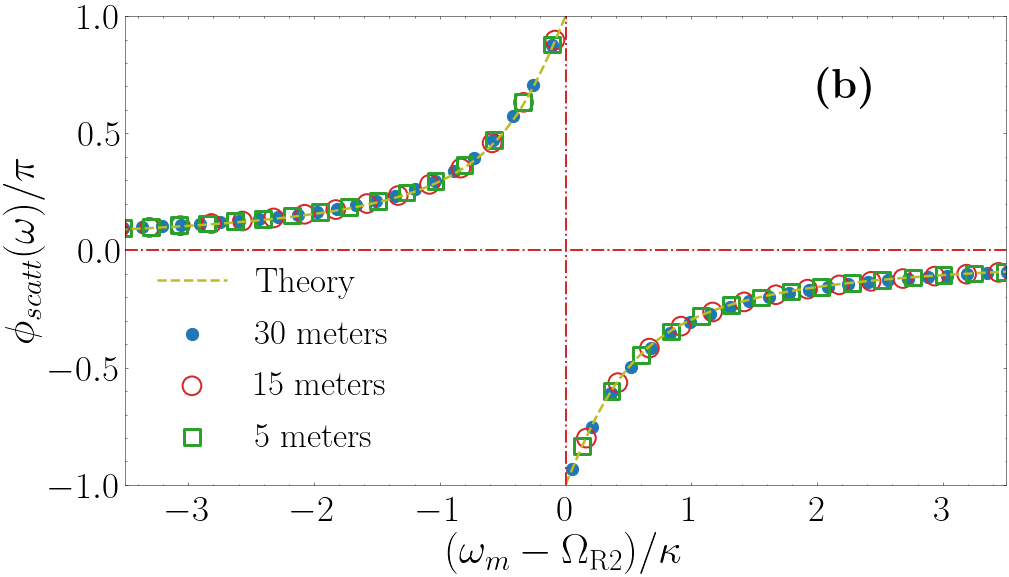

In [8]:
grid = {'hspace': 0.8, 'wspace': 0.5}
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), constrained_layout=True)
plt.rcParams.update({'font.size': 35})

ax1.scatter((scattering_30m[0]-scattering_30m[3])/scattering_30m[2], scattering_30m[1], s=150, color = 'tab:blue', label='30 meters')
ax1.scatter((scattering_15m[0]-scattering_15m[3])/scattering_15m[2], scattering_15m[1], s=350, facecolors='none', edgecolors='tab:red', linewidth=2, label='15 meters')
ax1.scatter((scattering_5m[0]-scattering_5m[3])/scattering_5m[2], scattering_5m[1], s=250, marker='s', facecolors='none', edgecolors='tab:green', linewidth=3, label='5 meters')

xlistm=np.linspace(-10,-0.001,1000)
phi_theom=np.real(-1j*np.log(((1j*(xlistm)+(0.5)))/(1j*(xlistm)-(0.5)))/pi)
xlistp=np.linspace(0.001,10,1000)
phi_theop=np.real(-1j*np.log(((1j*(xlistp)+(0.5)))/(1j*(xlistp)-(0.5)))/pi)

ax1.plot(xlistm,phi_theom,'--', color = 'tab:olive', linewidth=2.5, label='Theory')
ax1.plot(xlistp,phi_theop,'--', color = 'tab:olive', linewidth=2.5)

ax1.set_ylabel('$\\phi_{\\text{scatt}}(\\omega)/\\pi $ ', {'fontsize': 42})
ax1.set_xlabel('$(\\omega_m-\\Omega_{\\text{R2}})/\\kappa$',  {'fontsize': 42})



ax1.set_ylabel('$\\phi_{scatt}(\\omega)/\\pi $ ', {'fontsize': 42})

ax1.text(2, 0.65,'\\textbf{(b)}',color='black', weight='bold', fontsize=42)
# ax1.text(8.422, 0.4,'$\\Omega_{\\text{R2}} = 8.406(2\\pi\\mathrm{GHz})$',color='black', fontsize=35)


ax1.legend(loc='lower left')
ax1.yaxis.set_tick_params(labelsize=37)
ax1.xaxis.set_tick_params(labelsize=37)
ax1.xaxis.set_tick_params(pad=10)
ax1.set_ylim(-1,1)
ax1.set_xlim(-3.5,3.5)
ax1.axhline(y = 0, color = 'tab:red', linestyle='-.', linewidth = 2)
ax1.axvline(x = 0, color = 'tab:red', linestyle='-.', linewidth = 2)


plt.show()
# fig.savefig('../Newfigures/fig4b.svg')
# fig.savefig('../Newfigures/fig4b.pdf')

# Photonic scattering

We want to numerically study (based on the input-output formulas), the distortion and change in phase of the incoming photon with respect to the reflected ones. We have to do it properly, taking into account the phase effects due to each of the processes. We will begin with a reference photon
$$f(\omega)_{\rm ref_x} = f(\omega) e^{-i \varphi_x} e^{-i 2t \tilde{\omega}(k) } \hspace{.5cm} \text{with} \hspace{.5cm} \varphi_x = \pm \pi/2 + \frac{2}{\kappa} (\omega-\Omega_x) $$
wher $x = e,g$. This represents a photon that travels without distortion and interacts with a cavity for a time $\frac{2}{\kappa}$ acquiring after that interaction a phase $\pm \pi/2$.

The real (simulated) photon however suffers distortion from second order contributions of both non-linear dispersion relation and phase profile upon interaction

$$\tilde{f(\omega)}_x = f(\omega) e^{-i \varphi(\omega)_x} e^{-i 2t \omega(k) } \hspace{.5cm} \text{with} \hspace{.5cm} e^{-i \varphi(\omega)_x} = \frac{\kappa/2+i(\omega-(\Omega \pm \chi))}{-\kappa/2+i(\omega-(\Omega \pm \chi))}$$



We are going to choose a value of $$\chi = \left(\frac{1}{2} + \frac{1}{\sqrt{2}}\right) \kappa,$$ which, in the ideal case would cause phase change upon scattering of $\pi /4$. 

In [9]:
def analyze_scattering_eta(l=30, Nm = 2101, κ =2*pi*100*1e-3 , χ = None , η = 20, ω=2*π*8.406):
    
    '''Define the relevant quantities'''
    dϕdω = (4*κ)/(κ**2 + 4*(χ)**2)  # Derivative already evaluated at χ = (1/2 + 1/\sqrt{2}).
       
    control = setup.Exp2QB2Cavities(ω1=ω, ω2= ω - χ, g1=0, g2=0, κ1=0, κ2=κ, l=l, mmax=Nm)  
    H = control.Hamiltonian(g1=0, g2=0)  # Hamiltonian with node one disconnected from waveguide.
        
    ω_linear = control.ω1-(control.mcentral*π/l - control.mrelevant*π/l)*l/control.tprop  # Linear dispersion relation (all modes spaced evenly)
    
    ω = control.ωrelevant  # List of WG frequencies, just to make notation lighter
        
    tf = 2*control.tprop + dϕdω  # Total time, it includes propagation plus the interaction with the cavity 
    
    '''Initialize the state'''
    v0 = np.zeros(Nm+4)  # Initialize the state with a photon inside the WG.
    v0[4:]=1/np.cosh(π*η*(ω-control.ω1)/κ)  
    v0 = v0/(v0@v0)**(0.5)  
    
    '''Evolve the state right till the end'''
    vt= scipy.sparse.linalg.expm_multiply(-1j*tf*H,v0)
    
    '''Compute the differences between ideal and real dynamics'''    
    phot_refideal = v0[4:] * np.exp(-1j * tf * ω_linear) * np.exp(1j*((dϕdω)*(ω_linear-control.ω1)))  # photon that travels and interacts without distortion
    phot_theo = v0[4:] * np.exp(-1j * tf * ω     ) * ( (1j*(ω-  (control.ω2)) + (0.5*κ)) /   (1j*(ω-  (control.ω2))-(0.5*κ)) )  #  photon with the analytical distortion
    
    z_sim = np.vdot(phot_refideal,vt[4:])
    z_theo = np.vdot(phot_refideal,phot_theo)

    return np.abs(z_sim)**2, np.abs(z_theo)**2, np.abs(vt[3])**2

In [10]:
Netas=30
etalist=np.logspace(0,2,Netas)
κ = 2*pi*100*1e-3  # This is the kappa finally chosen for the sims.
χ = (1/2 + 1/np.sqrt(2))*κ  # This is the χ chosen as specified above. 

if os.path.exists('../Data/Scattering_Photon_L5_kappa100MHz_vseta.npy'):
    
    z_5m = np.load('../Data/Scattering_Photon_L5_kappa100MHz_vseta.npy')
    z_15m = np.load('../Data/Scattering_Photon_L15_kappa100MHz_vseta.npy')
    z_30m = np.load('../Data/Scattering_Photon_L30_kappa100MHz_vseta.npy')
    
else:    
    
    z_5m = [analyze_scattering_eta(l=5, Nm = 351, ω=2*π*8.41640839, η = η) for η in etalist]

    np.save('../Data/Scattering_Photon_L5_kappa100MHz_vseta.npy', z_5m)

    z_15m = [analyze_scattering_eta(l=15, Nm = 1051, ω=2*π*8.41014721, η = η) for η in etalist]

    np.save('../Data/Scattering_Photon_L15_kappa100MHz_vseta.npy', z_15m)

    z_30m = [analyze_scattering_eta(η = η, ω=2*π*8.4070193354791) for η in etalist]

    np.save('../Data/Scattering_Photon_L30_kappa100MHz_vseta.npy', z_30m)


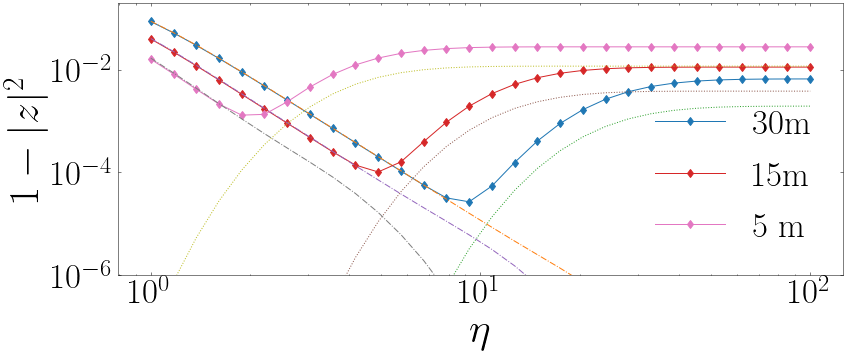

In [16]:
fig, (ax1) = plt.subplots(figsize=(13,5))

ax1.loglog(etalist,1-np.array(z_30m)[:,0],'d-',label='30m')
ax1.loglog(etalist,1-np.array(z_30m)[:,1],'-.')
ax1.loglog(etalist,np.array(z_30m)[:,2],':')

ax1.loglog(etalist,1-np.array(z_15m)[:,0],'d-',label='15m')
ax1.loglog(etalist,1-np.array(z_15m)[:,1],'-.')
ax1.loglog(etalist,np.array(z_15m)[:,2],':')


ax1.loglog(etalist,1-np.array(z_5m)[:,0],'d-',label='5 m')
ax1.loglog(etalist,1-np.array(z_5m)[:,1],'-.')
ax1.loglog(etalist,np.array(z_5m)[:,2],':')


ax1.set_ylabel('$1- |z|^2 $ ', {'fontsize': 42})
ax1.set_xlabel('$\\eta$',  {'fontsize': 42})




ax1.set_ylim([1e-6,.2])
ax1.legend()
plt.show()

